In [438]:
import spacy
# python -m spacy download en_core_web_sm
# python -m spacy download pl_core_news_sm
import re
import tarfile
import os
import matplotlib.pyplot as plt
import numpy as np
import regex
import pandas as pd
import morfeusz2
from elasticsearch_dsl import *
from elasticsearch_dsl import query
from elasticsearch import *
from elasticsearch.helpers import *

import os
import pickle

import spacy
from collections import Counter
from spacy.tokenizer import *
import string
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline


1. Make sure the texts in the corpus does not contain HTML code.
2. Use SpaCy [tokenizer API](https://spacy.io/api/tokenizer) to tokenize the text from the cleaned law corpus.
3. Compute **frequency list** for each of the processed files.
4. Aggregate the result to obtain one global frequency list.
5. Reject all entries that are shorter than 2 characters or contain non-letter characters (make sure to include Polish
   diacritics).
6. Make a plot in a logarithmic scale (for X and Y):
   1. X-axis should contain the **rank** of a term, meaning the first rank belongs to the term with the highest number of
      occurrences; the terms with the same number of occurrences should be ordered by their name,
   2. Y-axis should contain the **number of occurrences** of the term with given rank.
7. Install [Morfeusz](http://morfeusz.sgjp.pl/download/) (Binding dla Pythona) and use it to find all words that do not
   appear in that dictionary.
8. Find 30 words with the highest ranks that do not belong to the dictionary.
9. Find 30 random words (i.e. shuffle the words) with 5 occurrences that do not belong to the dictionary.
10. Use Levenshtein distance and the frequency list, to determine the most probable correction of the words from
   lists defined in points 8 and 9. (**Note**: You don't have to apply the distance directly. Any method that is more efficient than scanning the
   dictionary will be appreciated.)
11. Load [SGJP dictionary](http://morfeusz.sgjp.pl/download/) (Słownik SGJP dane tekstowe) to ElasticSearch (one document for each form) 
   and use fuzzy matching to obtain the possible
   corrections of the 30 words with 5 occurrences that do not belong to the dictionary.
12. Compare the results of your algorithm and output of ES. 
13. Draw conclusions regarding:
   * the distribution of words in the corpus,
   * the number of true misspellings vs. the number of unknown words,
   * the performance of your method compared to ElasticSearch,
   * the results provided by your method compared to ElasticSearch,
   * the validity of the obtained corrections.

In [314]:
nlp = spacy.load("pl_core_news_sm")
tokenizer = Tokenizer(nlp.vocab)


In [325]:

file_tokens = {}

i = 0
path="../data/ustawy"
for filename in os.listdir(path):
    with open(os.path.join(path, filename), 'r',encoding='utf-8') as f: # open in readonly mode
        text = f.read()
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = text.lower()
        text = regex.sub(r'\s+', ' ',text)


        doc = tokenizer(text)
        words = [token.text for token in doc if token.is_stop != True and token.is_punct != True and (len(token.text) >1) and token.is_alpha and not token.is_digit ]

        file_tokens[f.name] = words
        word_freq = Counter(words)
        i+=1
        if i % 200 == 0:
            print(i)
    

200
400
600
800
1000


In [326]:
word_freq ={}
for filename, tokens in file_tokens.items():
    word_freq[filename] = Counter(tokens)

In [327]:
word_freq_total = Counter({})
for counting in word_freq.values():
    word_freq_total.update(counting)


In [328]:
word_freq_total.most_common(5)

[('art', 82771),
 ('ust', 53356),
 ('poz', 45028),
 ('nr', 44941),
 ('mowa', 28782)]

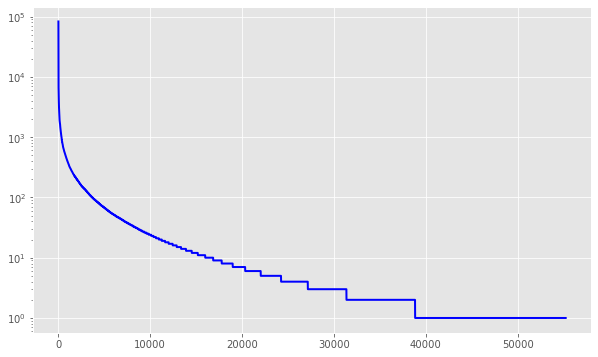

In [329]:
freq = [freq for (_,freq) in word_freq_total.most_common()]
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(range(1,len(word_freq_total)+1),freq, color='blue', lw=2)

ax.set_yscale('log')

plt.show()


In [340]:
from morfeusz2 import *
#Obiekt utworzony bez podawania parametrów konstruktora będzie używał domyślnego słownika SGJP i domyślnych ustawień opcji.
morf = Morfeusz()

not_found = {}
for (token,freq) in word_freq_total.most_common():
#     print('!'+token+'!',(morf.analyse(token)))
    if 'ign' in (morf.analyse(token))[0][2]:
#         print(freq,token)
        not_found[token] =freq
        
        

In [331]:
# print(not_found)

{'poz': 45028, 'dzu': 5766, 'późn': 1065, 'str': 514, 'gmo': 298, 'dzurz': 218, 'sww': 213, 'skw': 193, 'ex': 169, 'ike': 162, 'jt': 120, 'remediacji': 119, 'zm': 112, 'rozdz': 102, 'ure': 101, 'itp': 97, 'kn': 95, 'uke': 92, 'np': 85, 'cn': 82, 'pkwiu': 81, 'udt': 76, 'biobójczych': 63, 'bswsg': 63, 'bswp': 57, 'phs': 53, 'mgo': 41, 'fep': 41, 'utk': 39, 'frd': 36, 'ron': 35, 'doke': 34, 'cbśp': 34, 'haccp': 32, 'pcn': 32, 'vitro': 31, 'uokik': 31, 'its': 31, 'mst': 29, 'inulinowego': 29, 'efrrow': 27, 'ureaformu': 26, 'plk': 26, 'pcb': 25, 'biuretu': 25, 'tdt': 24, 'ych': 24, 'cu': 24, 'warszawacentrum': 23, 'disease': 22, 'tj': 21, 'iia': 19, 'iva': 19, 'prefinansowanie': 19, 'wymienion': 19, 'rozpuszc': 19, 'bankowania': 19, 'iiia': 18, 'ww': 18, 'zalny': 18, 'litb': 17, 'ureaform': 17, 'ie': 17, 'sędziegokomisarza': 16, 'cao': 16, 'zn': 16, 'zyskstrata': 16, 'wdt': 15, 'miejscea': 15, 'abw': 15, 'oo': 15, 'npk': 15, 'bielskubiałej': 14, 'wwym': 14, 'ae': 14, 'marpol': 14, 'iiar': 

In [332]:
counter = Counter(not_found).most_common(30)
counter

[('poz', 45028),
 ('dzu', 5766),
 ('późn', 1065),
 ('str', 514),
 ('gmo', 298),
 ('dzurz', 218),
 ('sww', 213),
 ('skw', 193),
 ('ex', 169),
 ('ike', 162),
 ('jt', 120),
 ('remediacji', 119),
 ('zm', 112),
 ('rozdz', 102),
 ('ure', 101),
 ('itp', 97),
 ('kn', 95),
 ('uke', 92),
 ('np', 85),
 ('cn', 82),
 ('pkwiu', 81),
 ('udt', 76),
 ('biobójczych', 63),
 ('bswsg', 63),
 ('bswp', 57),
 ('phs', 53),
 ('mgo', 41),
 ('fep', 41),
 ('utk', 39),
 ('frd', 36)]

In [356]:
import random
freq_5 = [token for (token,freq) in not_found.items() if freq==5 ]
random.shuffle(freq_5)
print(freq_5[0:30])


['fd', 'swine', 'rci', 'denitracyjne', 'wlkp', 'odbieralnice', 'kilogramówmetr', 'inci', 'betezda', 'teryto', 'rr', 'zawart', 'najmnie', 'rialnego', 'aiiibiiiciii', 'instrumen', 'łips', 'winopochodne', 'msr', 'schetyna', 'agave', 'wapnio', 'cz', 'odgazowywacze', 'regazyfikacyjnego', 'ijk', 'ym', 'chelatującym', 'iiin', 'państwamistronami']


In [376]:
from Levenshtein import distance as levenshtein_distance
Str1 = "Apple Inc."
Str2 = "Apple Ind"
Ratio = levenshtein_distance.calculate_levenshtein_distance(Str1.lower(),Str1.lower())

print(Ratio)


AttributeError: 'builtin_function_or_method' object has no attribute 'calculate_levenshtein_distance'

In [419]:
morf = Morfeusz()
analysis_result = morf.analyse("Ala je kota")

print(analysis_result)

[(0, 1, ('Ala', 'Ala', 'subst:sg:nom:f', ['imię'], [])), (0, 1, ('Ala', 'Al', 'subst:sg:gen.acc:m1', ['imię'], [])), (0, 1, ('Ala', 'Alo', 'subst:sg:gen.acc:m1', ['imię'], [])), (1, 2, ('je', 'on:S', 'ppron3:pl:acc:m2.m3.f.n:ter:akc.nakc:npraep', [], [])), (1, 2, ('je', 'on:S', 'ppron3:sg:acc:n:ter:akc.nakc:npraep', [], [])), (1, 2, ('je', 'jeść', 'fin:sg:ter:imperf', [], [])), (2, 3, ('kota', 'kota', 'subst:sg:nom:f', ['nazwa_pospolita'], [])), (2, 3, ('kota', 'kot:Sm1', 'subst:sg:gen.acc:m1', ['nazwa_pospolita'], ['pot.,środ.'])), (2, 3, ('kota', 'kot:Sm2', 'subst:sg:gen.acc:m2', ['nazwa_pospolita'], []))]


In [391]:
es = Elasticsearch("http://localhost:9200")
print(es.info())

connections.add_connection('python_client', es)
connections.create_connection(hosts=['localhost'])


{'name': 'x-dell', 'cluster_name': 'elasticsearch', 'cluster_uuid': 'hrJwCHZtSGm_1kBHAztvag', 'version': {'number': '7.10.1', 'build_flavor': 'default', 'build_type': 'deb', 'build_hash': '1c34507e66d7db1211f66f3513706fdf548736aa', 'build_date': '2020-12-05T01:00:33.671820Z', 'build_snapshot': False, 'lucene_version': '8.7.0', 'minimum_wire_compatibility_version': '6.8.0', 'minimum_index_compatibility_version': '6.0.0-beta1'}, 'tagline': 'You Know, for Search'}


<Elasticsearch([{'host': 'localhost'}])>

In [420]:
synonym = token_filter('my_name', type='synonym',
                       synonyms =
                       ["kpk => kodeks postępowania karnego",
                        "kpc => kodeks postępowania cywilnego",
                        "kk => kodeks karny",
                        "kc => kodeks cywilny"
                       ])

my_analyzer = analyzer('my_analyzer',
    tokenizer=tokenizer('standard'),
    filter=["lowercase",synonym,"morfologik_stem"]
)


# es.delete_by_query(index=['ustawa'], body={"query": {"match_all": {}}})


class Ustawa(Document):
    title = Text()
    created_at = Integer()
    content = Text(analyzer=my_analyzer)
    
    class Index:
        name = 'ustawa'
        
        

Ustawa.init()



In [421]:
iterations = 0
path="../data/ustawy"
for filename in os.listdir(path):
    with open(os.path.join(path, filename), 'r',encoding='utf-8') as f: # open in readonly mode
        
        year = int(re.search(r'.*\/([^\/]{4})',f.name).group(1))
        first = Ustawa(title=f.name,content=f.read(),created_at = year)
        
        first.save(using=es)
        iterations+=1


In [512]:
# with open('../data/sgjp-20211031.tab','r') as file:
import pandas as pd
filename = '../data/sgjp-20211031.tab'
# with open(filename) as fp:
#     skip = next(filter(
#         lambda x: x[1].startswith('ID'),
#         enumerate(fp)
#     ))[0]


f =pd.read_csv(filename,skiprows=29,usecols=[0,1],header=None,delim_whitespace='\t')
sjp =f[1]


print(f)

           0                         1
0         AA             AA:Sm3.n_ncol
1         AA             AA:Sm3.n_ncol
2        AAP                       AAP
3        ABB                       ABB
4        ABB                      ABBA
...      ...                       ...
7409385  Obj  Objawienie_świętego_Jana
7409386   Ez          Księga_Ezechiela
7409387   Lb              Księga_Liczb
7409388  N.N              nomen_nescio
7409389   st                     staro

[7409390 rows x 2 columns]


In [524]:

# def gendata():
#     mywords = ['kot', 'mysz', 'baz']
#     for word in mywords:
#         yield {
#             "_index": "mywords1",
#             "word": word,
#         }

# bulk(es, gendata(),request_timeout=10000)

sjp = set(sjp)

def gendata():
    i=0
    for word in sjp:
        if i%300000 ==0:
            print(i)
        i+=1
        yield {
            "_index": "sjp",
            "word": word,
        }
        

        

bulk(es, gendata(),request_timeout=10000 )



0
300000


(383709, [])

In [527]:
for i in sjp:
    print(i)
    break

gimnazjalista


In [536]:
def get_corrections(myword,myindex):
    result =es.search(index=myindex,
       query ={
            "fuzzy": {
                "word": {
                "value": myword,
                "fuzziness": 1
                }
            }
        }
    )
    hits = result['hits']['hits']


    hits_number = len(hits)

    # print(hits_number)

    suggestions = [i['_source']['word'] for i in hits]
    # print(suggestions)
    return suggestions


print(get_corrections('mysz','mywords1'))

NotFoundError: NotFoundError(404, 'index_not_found_exception', 'no such index [mywords1]', mywords1, index_or_alias)

In [537]:
def get_corrections_if_needed(word,index):
    corrections = get_corrections(word,index)
    if word in corrections:
        return ["Word belongs to the dictionary"]
    else:
        return corrections

print(get_corrections_if_needed('mysz','sjp'))

['Word belongs to the dictionary']


NameError: name 'Morfeuss' is not defined

In [427]:
import json
test_index = json.loads(json.dumps(inverse_index))

actions = [
    {
        '_index': 'test_index',
        '_type': 'application/json',
        '_id': i,
        '_source': {k: v},
    }
    for i, (k, v) in enumerate(test_index.items(), 1)
]


NameError: name 'inverse_index' is not defined

In [436]:
import Levenshtein

print(Levenshtein.distance("AA","BA!"))

2


In [435]:
freq_5

['fd',
 'swine',
 'rci',
 'denitracyjne',
 'wlkp',
 'odbieralnice',
 'kilogramówmetr',
 'inci',
 'betezda',
 'teryto',
 'rr',
 'zawart',
 'najmnie',
 'rialnego',
 'aiiibiiiciii',
 'instrumen',
 'łips',
 'winopochodne',
 'msr',
 'schetyna',
 'agave',
 'wapnio',
 'cz',
 'odgazowywacze',
 'regazyfikacyjnego',
 'ijk',
 'ym',
 'chelatującym',
 'iiin',
 'państwamistronami',
 'eudravigilance',
 'ami',
 'ppkt',
 'kpwig',
 'nitracyjne',
 'ponitracyjnego',
 'jed',
 'ośc',
 'contagious',
 'nfośigw',
 'sposb',
 'xxxixxliv',
 'ivn',
 'vista',
 'próbobiorców',
 'shigella',
 'urt',
 'tzn',
 'sędziakomisarz',
 'glinowo',
 'gj']

In [335]:
doc = tokenizer("ust ko9t")

for i in doc:
    print(i.is_alpha)

True
False


In [336]:
w = word_freq_total.most_common().sort()
w

In [337]:
ls =[("a",2),("c",5),("d",4),("d",5)]
w = sorted(ls,key=itemgetter(1,0))
print(w)

[('a', 2), ('d', 4), ('c', 5), ('d', 5)]


In [338]:
import regex
import string
s ='Q Hello \n\n ,.:Workd Q'.strip()
print(s)
s =s.translate(str.maketrans('', '', string.punctuation))

print(s)

Q Hello 

 ,.:Workd Q
Q Hello 

 Workd Q


In [112]:
text.lower()

' dzu z 2002 r nr 205 poz 1731 u s t a w a z dnia 30 października 2002 r o zmianie ustawy o przebudowie i modernizacji technicznej oraz finansowaniu sił zbrojnych rzeczypospolitej polskiej w latach 20012006 art 1 w ustawie z dnia 25 maja 2001 r o przebudowie i modernizacji technicznej oraz finansowaniu sił zbrojnych rzeczypospolitej polskiej w latach 20012006 dzu nr 76 poz 804 nr 85 poz 925 i nr 154 poz 1802 w art 7 1 w ust 1 skreśla się zdanie drugie 2 ust 2 i 3 otrzymują brzmienie 2 wydatki budżetowe o których mowa w ust 1 obejmują również wydatki obronne ujmowane w innych poza obroną narodową częściach budżetu państwa 3 udział wydatków majątkowych w wielkościach o których mowa w ust 1 wyniesie co najmniej 133 w 2003 r i co najmniej 20 w 2006 r art 2 ustawa wchodzi w życie z dniem 1 stycznia 2003 r '

In [75]:
import string
for filename in os.listdir(path):
    with open(os.path.join(path, filename), 'r',encoding='utf-8') as f: # open in readonly mode
        text = f.read()
#         text =text.translate(str.maketrans('', '', string.punctuation+'\n'))

        doc = tokenizer(text)
        words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
        print(words)
        break


['\n\n\n\n', 'Dz.U.', '1998', 'r.', 'Nr', '117,', 'poz.', '759', '                                     \n                                        \n                                        \n                                        \n                                        \n                                        \n                                     ', 'USTAWA', '\n                             ', 'dnia', '25', 'lipca', '1998', 'r.', '\n                                        \n                       ', 'zmianie', 'ustawy', 'systemie', 'oświaty', '\n                                        \n                                        \n                                     ', 'Art.', '1.', '\n', 'ustawie', 'dnia', '7', 'września', '1991', 'r.', 'systemie', 'oświaty', '(Dz.U.', '1996', 'r.', 'Nr', '67,', '\n', 'poz.', '329,', 'Nr', '106,', 'poz.', '496', '1997', 'r.', 'Nr', '28,', 'poz.', '153', 'Nr', '141,', 'poz.', '943)', '\n', 'wprowadza', 'następujące', 'zmiany:', '\n', '1)', 'art.', '1:

In [56]:
word_freq_all.most_common(4)

AttributeError: 'dict' object has no attribute 'most_common'

In [47]:
#multiprocessing python 
list(word_freq.values())[0].most_common(5)


[('\n       ', 123),
 ('ust.', 116),
 ('\n           ', 99),
 ('art.', 98),
 ('\n', 83)]

In [58]:
list(word_freq.values()).

Counter({'\n\n\n\n': 1,
         'Dz.U.': 1,
         '1998': 2,
         'r.': 11,
         'Nr': 6,
         '117,': 1,
         'poz.': 6,
         '759': 1,
         '                                     \n                                        \n                                        \n                                        \n                                        \n                                        \n                                     ': 1,
         'USTAWA': 1,
         '\n                             ': 1,
         'dnia': 6,
         '25': 1,
         'lipca': 1,
         '\n                                        \n                       ': 1,
         'zmianie': 1,
         'ustawy': 6,
         'systemie': 2,
         'oświaty': 35,
         '\n                                        \n                                        \n                                     ': 1,
         'Art.': 10,
         '1.': 17,
         '\n': 83,
         'ustawie': 4,
         '7'

In [42]:
print(type(list(file_tokens.values()[0]))

SyntaxError: unexpected EOF while parsing (<ipython-input-42-b7c2ede85770>, line 1)

In [45]:
Counter(['ala','ma', 'ma' ,'kota'])

Counter({'ala': 1, 'ma': 2, 'kota': 1})

In [ ]:
with open('file_tokens.pkl', 'wb') as outp:
    pickle.dump(file_tokens, outp, pickle.HIGHEST_PROTOCOL)


In [3]:
nlp = spacy.load("en_core_web_sm")
tokens = nlp("dog cat banana afskfsd")

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

dog True 4.8634477 True
cat True 5.2525845 True
banana True 5.3935223 True
afskfsd True 5.5341754 True


In [17]:
from spacy.lang.pl.examples import sentences 

nlp = spacy.load("pl_core_news_sm")
doc = nlp(sentences[0])
print(dir(doc))
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)

['_', '__bytes__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__unicode__', '_bulk_merge', '_get_array_attrs', '_py_tokens', '_realloc', '_vector', '_vector_norm', 'cats', 'char_span', 'copy', 'count_by', 'doc', 'ents', 'extend_tensor', 'from_array', 'from_bytes', 'from_dict', 'from_disk', 'from_docs', 'get_extension', 'get_lca_matrix', 'has_annotation', 'has_extension', 'has_unknown_spaces', 'has_vector', 'is_nered', 'is_parsed', 'is_sentenced', 'is_tagged', 'lang', 'lang_', 'mem', 'noun_chunks', 'noun_chunks_iterator', 'remove_extension', 'retokenize', 'sentiment', 'sents', 'set_ents', 'set_extension', 'similarity', 'spans', 'tensor', 'text', 'text_with_ws'

In [12]:
iterations = 0
path="../data/ustawy"
for filename in os.listdir(path):
    with open(os.path.join(path, filename), 'r',encoding='utf-8') as f: # open in readonly mode
        text = f.read()
        doc = nlp(text)
        iterations+=1
        if iterations==10:
            break
    



In [13]:
import spacy
nlp = spacy.load("en_core_web_sm")

list_of_words = ['Pies', 'jump', 'catch']

def word_count(string):
    words_counted = 0
    my_string = nlp(string)

    for token in my_string:
        # actual word
        word = token.text
        # lemma
        lemma_word = token.lemma_
        # part of speech
        word_pos = token.pos_
        if lemma_word in list_of_words:
            words_counted += 1
            print(lemma_word)
    return words_counted


sentence = "I ran, jumped, and caught the ball."
words_counted = word_count(sentence)
print(words_counted)

jump
catch
2


In [10]:

nlp = spacy.load("pl_core_news_sm")
# text = 
doc = nlp(text)
#remove stopwords and punctuations
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
word_freq = Counter(words)
common_words = word_freq
print (common_words)


NameError: name 'text' is not defined

In [5]:
from spacy import *
from collections import Counter
nlp = spacy.load("pl_core_news_sm")

texts = ["One document.", "...", "Lots of documents"]
for doc in tokenizer.pipe(texts, batch_size=50):
    print(doc)
    # pass


AttributeError: module 'spacy.tokenizer' has no attribute 'pipe'

In [39]:

import spacy
from spacy.symbols import ORTH
nlp = spacy.load("pl_core_news_sm")
doc = nlp("lemme that")
print([w.text for w in doc])

special_case = [{ORTH: "lem"}, {"ORTH": "me"}]
nlp.tokenizer.add_special.case("lemme", special_case)
print([w.text for w in nlp("lemme that")])

['lemme', 'that']


AttributeError: 'spacy.tokenizer.Tokenizer' object has no attribute 'add_special'